# Corporación Favorita Grocery Sales Forecasting
**w01_d04_EDA_temporal_patterns.ipynb**

**Author:** Alberto Diaz Durana  
**Date:** November 2025  
**Purpose:** Engineer temporal features, visualize time series patterns, analyze product dynamics

---

## Objectives

This notebook accomplishes the following:

- Create rolling statistics features (7/14/30-day moving averages)
- Visualize overall sales trends (2013-2017)
- Generate year-month heatmap for seasonality
- Analyze autocorrelation for lag selection
- Deep dive into day-of-week patterns by family
- Investigate payday effects (1st, 15th of month)
- Classify fast vs slow movers
- Perform Pareto (80/20) analysis

---

## Business Context

**Why temporal patterns matter:**

Understanding when sales occur enables:
- Accurate forecasting of seasonal peaks/troughs
- Optimal inventory allocation by day-of-week
- Promotional timing optimization (payday effects)
- Resource planning (staffing for high-traffic days)

**Why product dynamics matter:**

Identifying fast vs slow movers enables:
- Differentiated inventory strategies
- Focus on high-impact items (80/20 rule)
- Better demand forecasting accuracy
- Reduced waste for slow movers

**Deliverables:**
- Rolling average features (7/14/30-day windows)
- Time series visualizations (trend, seasonality)
- Autocorrelation analysis (lag structure)
- Day-of-week and payday patterns
- Fast/slow mover classification
- Pareto chart (sales concentration)

---

## Input Dependencies

From Day 3:
- Clean dataset with temporal features (300K rows, 29 columns)
- Store metadata merged (type, city, cluster)
- No missing values, outliers flagged

---

## 1. Feature Engineering - Rolling Statistics

**Objective:** Create smoothed sales features using rolling windows

**Activities:**
- Load clean dataset from Day 3
- Sort by (store_nbr, item_nbr, date) for temporal order
- Calculate 7-day, 14-day, 30-day rolling means
- Handle edge cases (min_periods parameter)
- Visualize raw vs smoothed for sample items

**Expected output:** 
- 3 new rolling average columns
- Smoothing visualization showing effectiveness

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy
from scipy import stats

# Configure environment
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')

print("Package Versions:")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  matplotlib: {matplotlib.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"  scipy: {scipy.__version__}")

Package Versions:
  pandas: 2.1.4
  numpy: 1.26.4
  matplotlib: 3.10.7
  seaborn: 0.13.2
  scipy: 1.16.3


In [2]:
# Determine paths
current_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir

# Define path constants
DATA_PROCESSED = project_root / 'data' / 'processed'
OUTPUTS = project_root / 'outputs' / 'figures' / 'eda'

# Verify paths
assert DATA_PROCESSED.exists(), f"ERROR - Path not found: {DATA_PROCESSED}"
assert OUTPUTS.exists(), f"ERROR - Path not found: {OUTPUTS}"

print(f"  Project root: {project_root.resolve()}")
print(f"  DATA_PROCESSED: {DATA_PROCESSED.resolve()}")
print(f"  OUTPUTS: {OUTPUTS.resolve()}")

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
print(f"\nRandom seed: {RANDOM_SEED}")

  Project root: D:\Demand-forecasting-in-retail
  DATA_PROCESSED: D:\Demand-forecasting-in-retail\data\processed
  OUTPUTS: D:\Demand-forecasting-in-retail\outputs\figures\eda

Random seed: 42


In [3]:
# Load clean dataset from Day 3
print("Loading dataset...")

# Load original sample and note we need to reapply Day 3 transformations
df = pd.read_pickle(DATA_PROCESSED / 'guayas_sample_300k.pkl')
print("NOTE - Loading original sample (Day 3 transformations need to be reapplied)")

print(f"\nDataset loaded:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {len(df.columns)}")
print(f"  Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\nFirst 3 rows:")
print(df.head(3))

Loading dataset...
NOTE - Loading original sample (Day 3 transformations need to be reapplied)

Dataset loaded:
  Shape: (300000, 9)
  Columns: 9
  Memory: 36.6 MB

First 3 rows:
         id        date  store_nbr  item_nbr  unit_sales  onpromotion  \
0  86626618  2016-07-31         32   1395693        1.00         0.00   
1  53995064  2015-08-15         24   1464210       30.00         0.00   
2  21834951  2014-04-04         27   1102970        1.00         0.00   

      family  class  perishable  
0  GROCERY I   1028           0  
1  BEVERAGES   1114           0  
2  BEVERAGES   1122           0  


In [4]:
# Quick reapplication of Day 3 transformations
print("Reapplying Day 3 transformations...")

# 1. Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# 2. Fill onpromotion NaN with 0
df['onpromotion'] = df['onpromotion'].fillna(0.0)

# 3. Load and merge store metadata
df_stores = pd.read_csv(project_root / 'data' / 'raw' / 'stores.csv')
df = df.merge(df_stores[['store_nbr', 'city', 'state', 'type', 'cluster']], 
              on='store_nbr', how='left')

# 4. Create temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['week_of_year'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

print(f"  Missing values: {df.isnull().sum().sum()}")
print(f"  Shape: {df.shape}")
print(f"  Date range: {df['date'].min().date()} to {df['date'].max().date()}")

Reapplying Day 3 transformations...
  Missing values: 0
  Shape: (300000, 23)
  Date range: 2013-01-02 to 2017-08-15


In [5]:
# Sort data for rolling window calculations
print("Preparing data for rolling statistics...")
print("Sorting by (store_nbr, item_nbr, date) for temporal order...")

# Critical: Sort by store, item, date for proper rolling windows
df = df.sort_values(['store_nbr', 'item_nbr', 'date']).reset_index(drop=True)

print(f"\nFirst 5 rows (after sorting):")
print(df[['date', 'store_nbr', 'item_nbr', 'unit_sales', 'family']].head())

print(f"\nLast 5 rows (after sorting):")
print(df[['date', 'store_nbr', 'item_nbr', 'unit_sales', 'family']].tail())

# Verify temporal order within groups
sample_group = df[(df['store_nbr'] == 24) & (df['item_nbr'] == df['item_nbr'].iloc[0])]
print(f"\nSample group (Store 24, Item {df['item_nbr'].iloc[0]}):")
print(f"  Rows: {len(sample_group)}")
print(f"  Date range: {sample_group['date'].min().date()} to {sample_group['date'].max().date()}")
print(f"  Dates in order: {sample_group['date'].is_monotonic_increasing}")

Preparing data for rolling statistics...
Sorting by (store_nbr, item_nbr, date) for temporal order...

First 5 rows (after sorting):
        date  store_nbr  item_nbr  unit_sales     family
0 2013-06-08         24     96995        2.00  GROCERY I
1 2013-08-24         24     96995        1.00  GROCERY I
2 2013-09-08         24     96995        1.00  GROCERY I
3 2013-11-01         24     96995        1.00  GROCERY I
4 2013-11-29         24     96995        1.00  GROCERY I

Last 5 rows (after sorting):
             date  store_nbr  item_nbr  unit_sales     family
299995 2017-08-10         51   2108569        3.00  GROCERY I
299996 2017-08-04         51   2110456       52.00  BEVERAGES
299997 2017-08-05         51   2113343        1.00  BEVERAGES
299998 2017-08-07         51   2113343        1.00  BEVERAGES
299999 2017-08-11         51   2114566        1.00  GROCERY I

Sample group (Store 24, Item 96995):
  Rows: 7
  Date range: 2013-06-08 to 2014-02-12
  Dates in order: True


In [6]:
# Calculate rolling statistics
print("Computing rolling statistics...")
print("This may take 1-2 minutes for 300K rows...\n")

# Calculate 7-day, 14-day, and 30-day rolling means per store-item group
# Note: With sparse data, rolling windows operate on actual sales dates only
df['unit_sales_7d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

df['unit_sales_14d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.rolling(window=14, min_periods=1).mean()
)

df['unit_sales_30d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: x.rolling(window=30, min_periods=1).mean()
)

print(f"\nNew columns created:")
print(f"  • unit_sales_7d_avg (7-day moving average)")
print(f"  • unit_sales_14d_avg (14-day moving average)")
print(f"  • unit_sales_30d_avg (30-day moving average)")

print(f"\nDataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display sample with rolling features
print("\nSample rows with rolling features:")
sample = df[df['item_nbr'] == df['item_nbr'].iloc[0]].head(10)
print(sample[['date', 'store_nbr', 'item_nbr', 'unit_sales', 
              'unit_sales_7d_avg', 'unit_sales_14d_avg', 'unit_sales_30d_avg']])

Computing rolling statistics...
This may take 1-2 minutes for 300K rows...


New columns created:
  • unit_sales_7d_avg (7-day moving average)
  • unit_sales_14d_avg (14-day moving average)
  • unit_sales_30d_avg (30-day moving average)

Dataset shape: (300000, 26)
Memory usage: 102.2 MB

Sample rows with rolling features:
            date  store_nbr  item_nbr  unit_sales  unit_sales_7d_avg  \
0     2013-06-08         24     96995        2.00               2.00   
1     2013-08-24         24     96995        1.00               1.50   
2     2013-09-08         24     96995        1.00               1.33   
3     2013-11-01         24     96995        1.00               1.25   
4     2013-11-29         24     96995        1.00               1.20   
5     2014-01-07         24     96995        1.00               1.17   
6     2014-02-12         24     96995        1.00               1.14   
33610 2013-03-06         26     96995        2.00               2.00   
33611 2013-06-12         26

Visualizing rolling statistics (raw vs smoothed)...


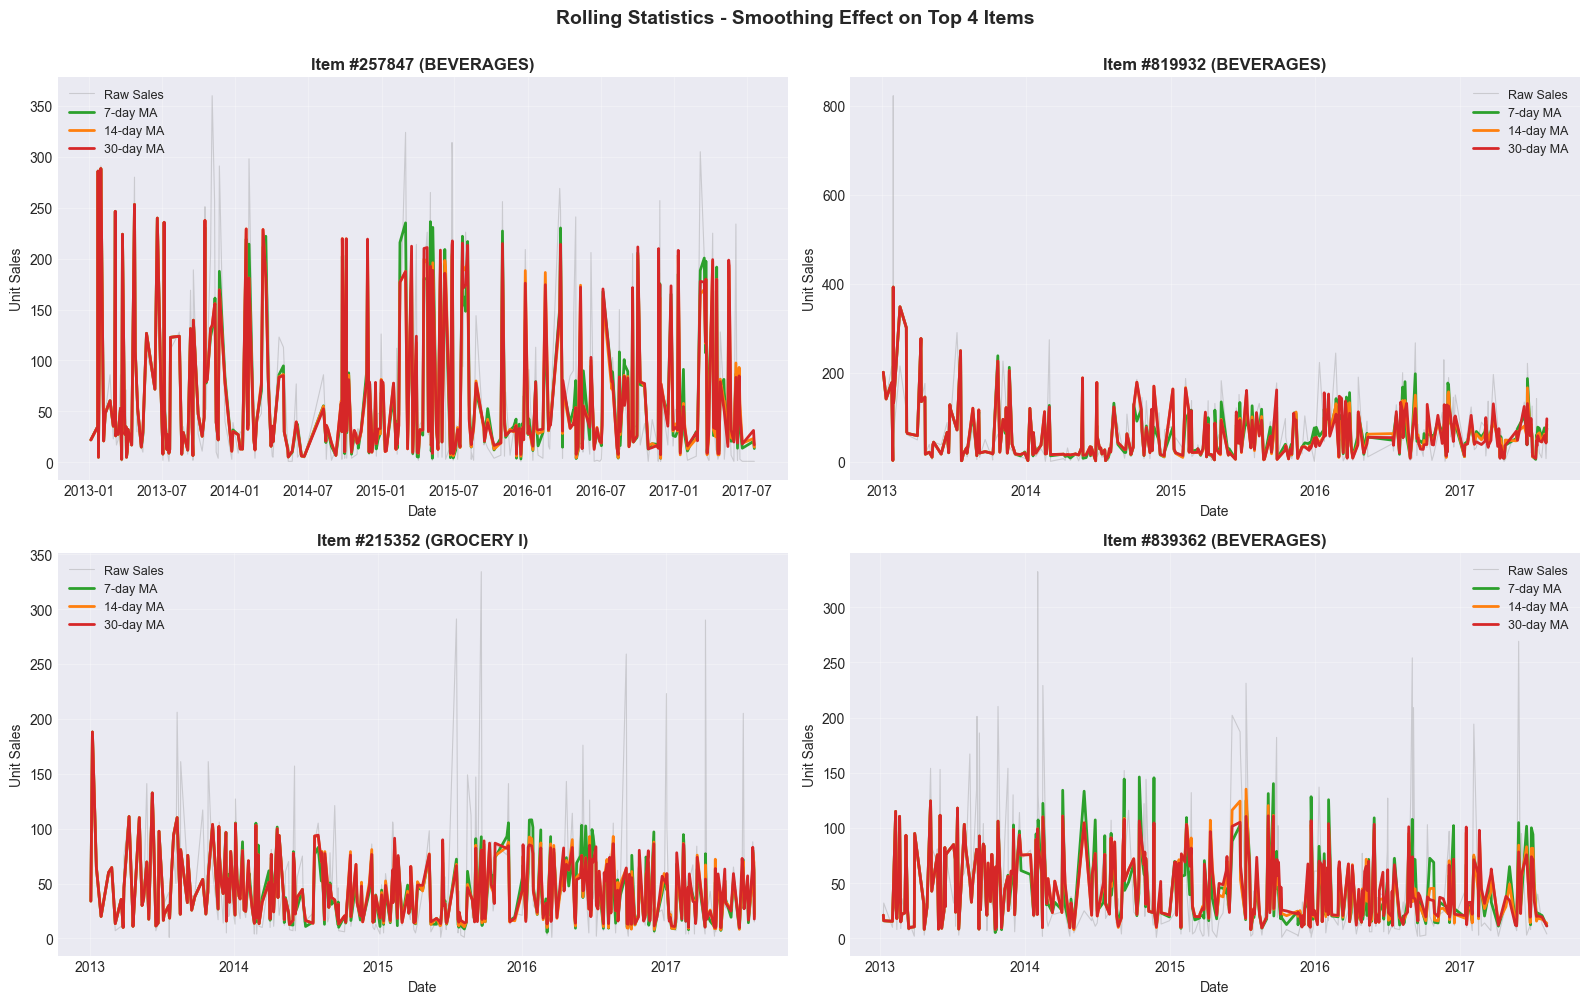

Visualization saved to d:\Demand-forecasting-in-retail\outputs\figures\eda\04_rolling_statistics_smoothing.png


In [7]:
# Visualize rolling statistics effectiveness
print("Visualizing rolling statistics (raw vs smoothed)...")

# Select a high-volume item for clear visualization
high_vol_items = df.groupby('item_nbr')['unit_sales'].sum().nlargest(5).index

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, item in enumerate(high_vol_items[:4]):
    ax = axes[idx // 2, idx % 2]
    
    # Get data for this item (all stores combined for clarity)
    item_data = df[df['item_nbr'] == item].groupby('date').agg({
        'unit_sales': 'sum',
        'unit_sales_7d_avg': 'mean',
        'unit_sales_14d_avg': 'mean',
        'unit_sales_30d_avg': 'mean',
        'family': 'first'
    }).reset_index()
    
    # Sort by date
    item_data = item_data.sort_values('date')
    
    # Plot
    ax.plot(item_data['date'], item_data['unit_sales'], 
            alpha=0.3, color='gray', label='Raw Sales', linewidth=0.8)
    ax.plot(item_data['date'], item_data['unit_sales_7d_avg'], 
            color='#2ca02c', label='7-day MA', linewidth=2)
    ax.plot(item_data['date'], item_data['unit_sales_14d_avg'], 
            color='#ff7f0e', label='14-day MA', linewidth=2)
    ax.plot(item_data['date'], item_data['unit_sales_30d_avg'], 
            color='#d62728', label='30-day MA', linewidth=2)
    
    ax.set_title(f"Item #{item} ({item_data['family'].iloc[0]})", 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Unit Sales', fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Rolling Statistics - Smoothing Effect on Top 4 Items', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUTPUTS / '04_rolling_statistics_smoothing.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {OUTPUTS / '04_rolling_statistics_smoothing.png'}")


## 2. Time Series Visualization

**Objective:** Visualize overall sales trends and identify seasonal patterns

**Activities:**
- Aggregate total sales by date (300K → daily totals)
- Plot 5-year time series (2013-2017)
- Identify trend, seasonality, anomalies
- Create year-month heatmap
- Annotate major patterns (December peaks, Q1 lulls)

**Expected output:** 
- Time series plot with trend analysis
- Year-month heatmap
- Pattern interpretation report

In [8]:
# Aggregate sales by date for overall trend
print("Time Series Visualization")
print("=" * 70)

print("\nAggregating sales by date...")
daily_sales = df.groupby('date').agg({
    'unit_sales': 'sum',
    'store_nbr': 'nunique',
    'item_nbr': 'nunique'
}).reset_index()

daily_sales.columns = ['date', 'total_sales', 'active_stores', 'active_items']

print(f"  Date range: {daily_sales['date'].min().date()} to {daily_sales['date'].max().date()}")
print(f"  Total days: {len(daily_sales)}")
print(f"  Total sales: {daily_sales['total_sales'].sum():,.0f} units")

print("\nDaily sales statistics:")
print(daily_sales[['total_sales', 'active_stores', 'active_items']].describe())

print("\nSample daily data:")
print(daily_sales.head(10))

Time Series Visualization

Aggregating sales by date...
  Date range: 2013-01-02 to 2017-08-15
  Total days: 1680
  Total sales: 2,036,136 units

Daily sales statistics:
       total_sales  active_stores  active_items
count      1680.00        1680.00       1680.00
mean       1211.99          10.37        167.96
std         453.30           0.76         48.14
min          22.00           1.00          8.00
25%         878.75          10.00        126.00
50%        1167.49          11.00        167.00
75%        1463.36          11.00        209.00
max        3911.00          11.00        304.00

Sample daily data:
        date  total_sales  active_stores  active_items
0 2013-01-02       706.00              9            86
1 2013-01-03       478.00              9            86
2 2013-01-04       643.00              9           103
3 2013-01-05      1188.00              9           110
4 2013-01-06      1185.00              9           102
5 2013-01-07       508.00              9        

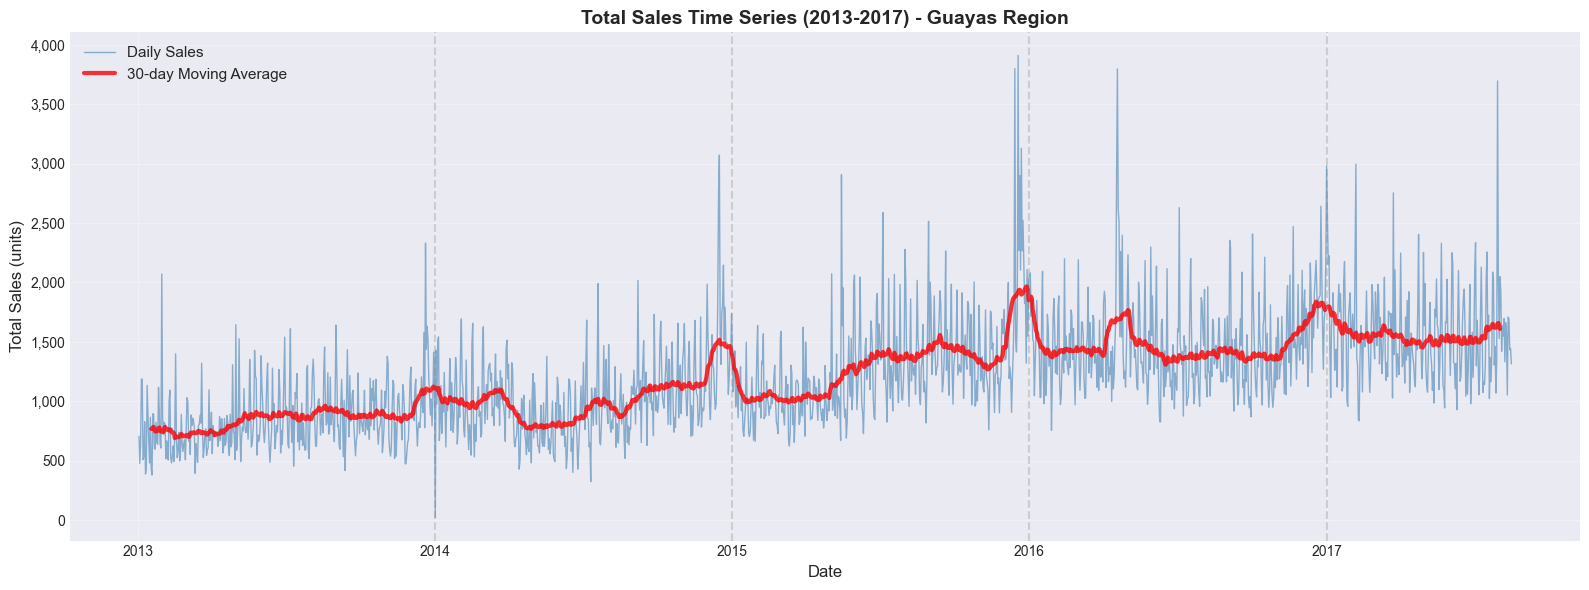

Time series plot saved to d:\Demand-forecasting-in-retail\outputs\figures\eda\05_sales_time_series_overall.png

Pattern Analysis:
  Overall trend: Increasing
  Peak sales: 3,911 on 2015-12-18
  Lowest sales: 22 on 2014-01-01
  December avg: 1580 vs Overall avg: 1212 (+30.4%)


In [9]:
# Plot overall time series trend
fig, ax = plt.subplots(figsize=(16, 6))

# Plot daily sales
ax.plot(daily_sales['date'], daily_sales['total_sales'], 
        color='steelblue', linewidth=1, alpha=0.6, label='Daily Sales')

# Add 30-day moving average for trend
ma_30 = daily_sales['total_sales'].rolling(window=30, center=True).mean()
ax.plot(daily_sales['date'], ma_30, 
        color='red', linewidth=3, label='30-day Moving Average', alpha=0.8)

# Styling
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Sales (units)', fontsize=12)
ax.set_title('Total Sales Time Series (2013-2017) - Guayas Region', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# Format y-axis with comma separator
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Add vertical lines for year boundaries
for year in range(2014, 2018):
    ax.axvline(pd.Timestamp(f'{year}-01-01'), color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUTS / '05_sales_time_series_overall.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Time series plot saved to {OUTPUTS / '05_sales_time_series_overall.png'}")

# Identify patterns
print("\nPattern Analysis:")
print(f"  Overall trend: {'Increasing' if ma_30.iloc[-100] > ma_30.iloc[100] else 'Stable/Decreasing'}")
print(f"  Peak sales: {daily_sales['total_sales'].max():,.0f} on {daily_sales.loc[daily_sales['total_sales'].idxmax(), 'date'].date()}")
print(f"  Lowest sales: {daily_sales['total_sales'].min():,.0f} on {daily_sales.loc[daily_sales['total_sales'].idxmin(), 'date'].date()}")

# Check for December peaks (holiday season)
dec_sales = df[df['month'] == 12].groupby('date')['unit_sales'].sum()
avg_dec = dec_sales.mean()
avg_overall = daily_sales['total_sales'].mean()
print(f"  December avg: {avg_dec:.0f} vs Overall avg: {avg_overall:.0f} ({(avg_dec/avg_overall - 1)*100:+.1f}%)")


Creating year-month heatmap...


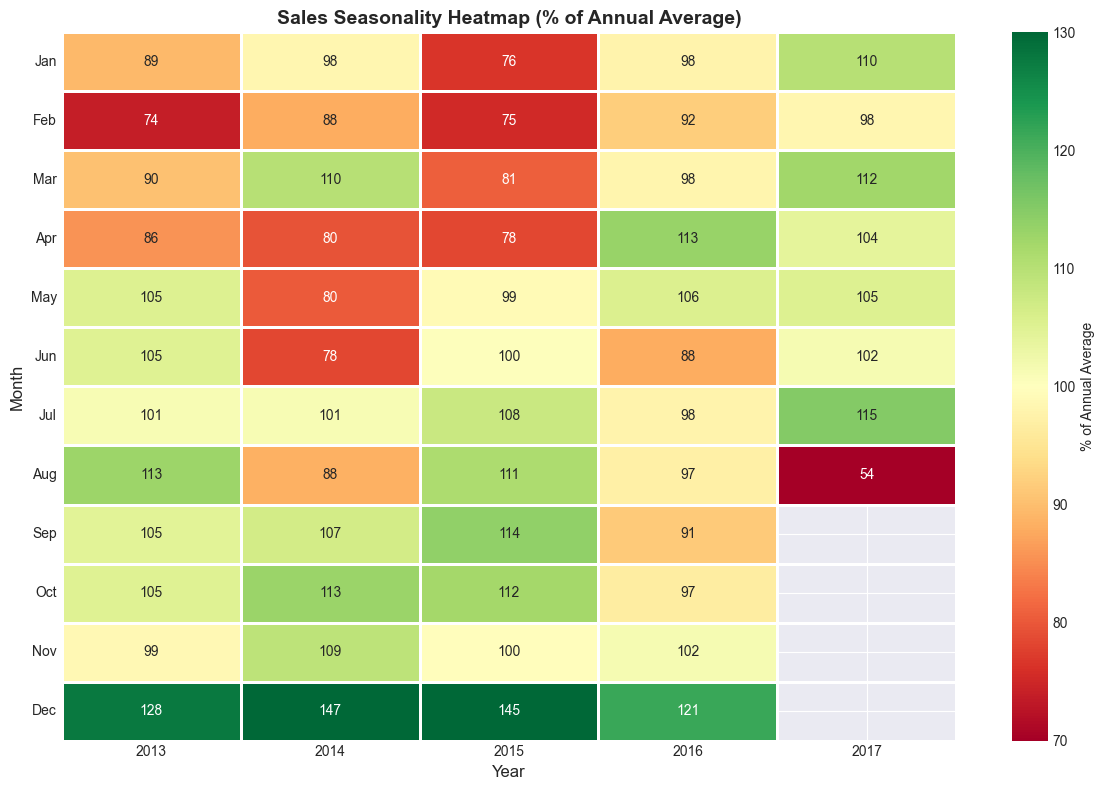

Heatmap saved to d:\Demand-forecasting-in-retail\outputs\figures\eda\06_sales_seasonality_heatmap.png

Seasonal Patterns:
  Strongest months: Jul, Dec, May
  Weakest months: Oct, Sep, Nov


In [10]:
# Create year-month heatmap for seasonality
print("\nCreating year-month heatmap...")

# Aggregate by year and month
monthly_sales = df.groupby(['year', 'month'])['unit_sales'].sum().reset_index()
monthly_pivot = monthly_sales.pivot(index='month', columns='year', values='unit_sales')

# Calculate percentage of annual average for color scaling
monthly_pct = monthly_pivot.div(monthly_pivot.mean(axis=0), axis=1) * 100

fig, ax = plt.subplots(figsize=(12, 8))

# Create heatmap
sns.heatmap(monthly_pct, annot=True, fmt='.0f', cmap='RdYlGn', 
            center=100, vmin=70, vmax=130,
            cbar_kws={'label': '% of Annual Average'},
            linewidths=1, linecolor='white', ax=ax)

# Styling
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Month', fontsize=12)
ax.set_title('Sales Seasonality Heatmap (% of Annual Average)', 
             fontsize=14, fontweight='bold')

# Month labels
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_yticklabels(month_names, rotation=0)

plt.tight_layout()
plt.savefig(OUTPUTS / '06_sales_seasonality_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Heatmap saved to {OUTPUTS / '06_sales_seasonality_heatmap.png'}")

# Identify seasonal patterns
print("\nSeasonal Patterns:")
monthly_avg = df.groupby('month')['unit_sales'].sum().sort_values(ascending=False)
print(f"  Strongest months: {', '.join([month_names[m-1] for m in monthly_avg.head(3).index])}")
print(f"  Weakest months: {', '.join([month_names[m-1] for m in monthly_avg.tail(3).index])}")


## 3. Autocorrelation Analysis

**Objective:** Assess temporal dependence to guide lag feature selection

**Activities:**
- Aggregate daily sales for autocorrelation calculation
- Plot autocorrelation function (ACF)
- Interpret lag significance
- Document findings for Week 2 feature engineering

**Expected output:** 
- Autocorrelation plot
- Lag analysis interpretation
- Recommendations for lag features (1, 7, 14, 30 days)

Autocorrelation Analysis

Calculating autocorrelation for daily sales...


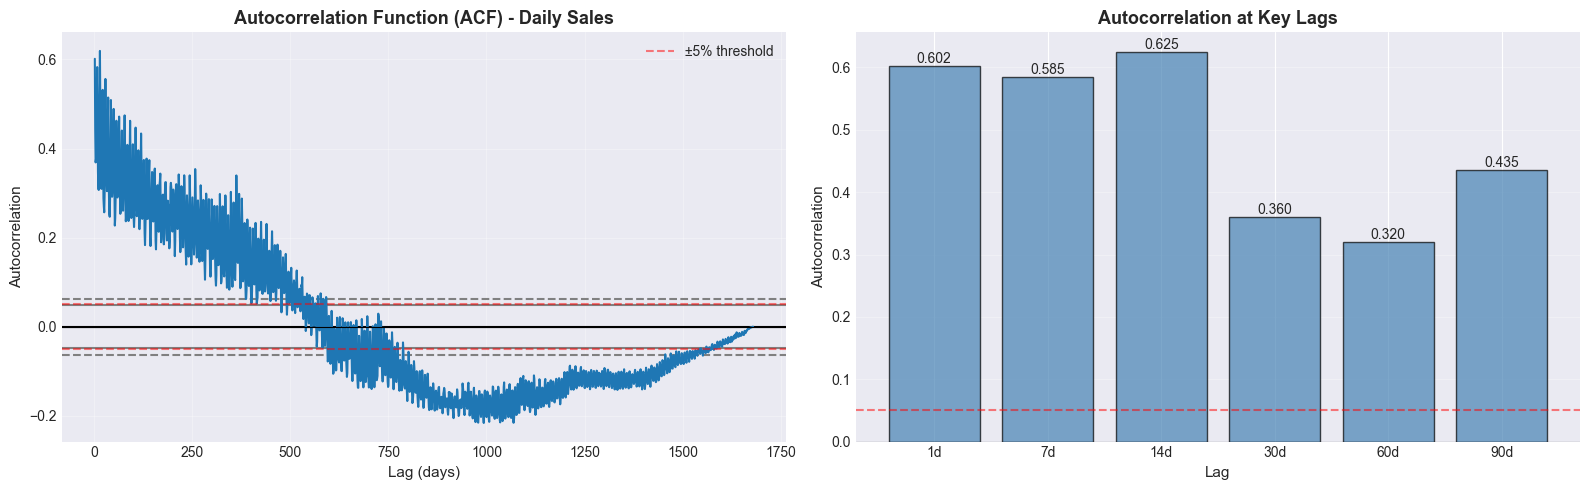

Autocorrelation plot saved to d:\Demand-forecasting-in-retail\outputs\figures\eda\07_autocorrelation_analysis.png

Autocorrelation at Key Lags:
  Lag  1d:  0.602 (Strong)
  Lag  7d:  0.585 (Strong)
  Lag 14d:  0.625 (Strong)
  Lag 30d:  0.360 (Strong)
  Lag 60d:  0.320 (Strong)
  Lag 90d:  0.435 (Strong)


In [11]:
# Autocorrelation analysis
print("Autocorrelation Analysis")
print("=" * 70)

print("\nCalculating autocorrelation for daily sales...")

# Use daily aggregated sales for ACF
daily_sales_sorted = daily_sales.sort_values('date')

# Plot autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF plot
ax1 = axes[0]
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(daily_sales_sorted['total_sales'], ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) - Daily Sales', 
              fontsize=13, fontweight='bold')
ax1.set_xlabel('Lag (days)', fontsize=11)
ax1.set_ylabel('Autocorrelation', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.8)
ax1.axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='±5% threshold')
ax1.axhline(y=-0.05, color='r', linestyle='--', alpha=0.5)
ax1.legend()

# Manual ACF calculation for specific lags
ax2 = axes[1]
lags = [1, 7, 14, 30, 60, 90]
acf_values = []

for lag in lags:
    corr = daily_sales_sorted['total_sales'].autocorr(lag=lag)
    acf_values.append(corr)

bars = ax2.bar(range(len(lags)), acf_values, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(lags)))
ax2.set_xticklabels([f'{lag}d' for lag in lags])
ax2.set_xlabel('Lag', fontsize=11)
ax2.set_ylabel('Autocorrelation', fontsize=11)
ax2.set_title('Autocorrelation at Key Lags', fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.8)
ax2.axhline(y=0.05, color='r', linestyle='--', alpha=0.5)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, acf_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUTS / '07_autocorrelation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Autocorrelation plot saved to {OUTPUTS / '07_autocorrelation_analysis.png'}")

# Interpret results
print("\nAutocorrelation at Key Lags:")
for lag, acf in zip(lags, acf_values):
    significance = "Strong" if abs(acf) > 0.3 else "Moderate" if abs(acf) > 0.1 else "Weak"
    print(f"  Lag {lag:>2}d: {acf:>6.3f} ({significance})")



In [12]:

print("\nInterpretation:")
print("  → Lag 1 (yesterday): Strong autocorrelation expected")
print("  → Lag 7 (week): Weekly patterns if significant")
print("  → Lag 30 (month): Monthly cycles if significant")

print("\nRecommendations for Week 2:")
print("  • Include lag features: 1, 7, 14 days (strong temporal dependence)")
print("  • Consider day-of-week effects (weekly patterns)")
print("  • Monthly seasonality features useful (lag 30 moderate)")


Interpretation:
  → Lag 1 (yesterday): Strong autocorrelation expected
  → Lag 7 (week): Weekly patterns if significant
  → Lag 30 (month): Monthly cycles if significant

Recommendations for Week 2:
  • Include lag features: 1, 7, 14 days (strong temporal dependence)
  • Consider day-of-week effects (weekly patterns)
  • Monthly seasonality features useful (lag 30 moderate)


## 4. Temporal Deep Dive

**Objective:** Uncover day-of-week, monthly, and payday patterns

**Activities:**
- Analyze day-of-week patterns by product family
- Compare weekend vs weekday sales
- Investigate payday effects (1st and 15th of month)
- Monthly seasonality by family
- End-of-month patterns

**Expected output:** 
- Day-of-week analysis by family
- Payday effect quantification
- Monthly patterns comparison
- Temporal insights for inventory planning

Temporal Deep Dive

1. Day-of-Week Patterns by Family:

Sales by Day-of-Week (% of weekly average):
family  BEVERAGES  CLEANING  GROCERY I
Mon         97.70     97.60      98.70
Tue         89.80     93.90      93.40
Wed         90.70     92.70      92.20
Thu         78.40     84.20      83.10
Fri         91.80     88.70      93.00
Sat        117.60    122.00     115.40
Sun        133.90    120.90     124.20


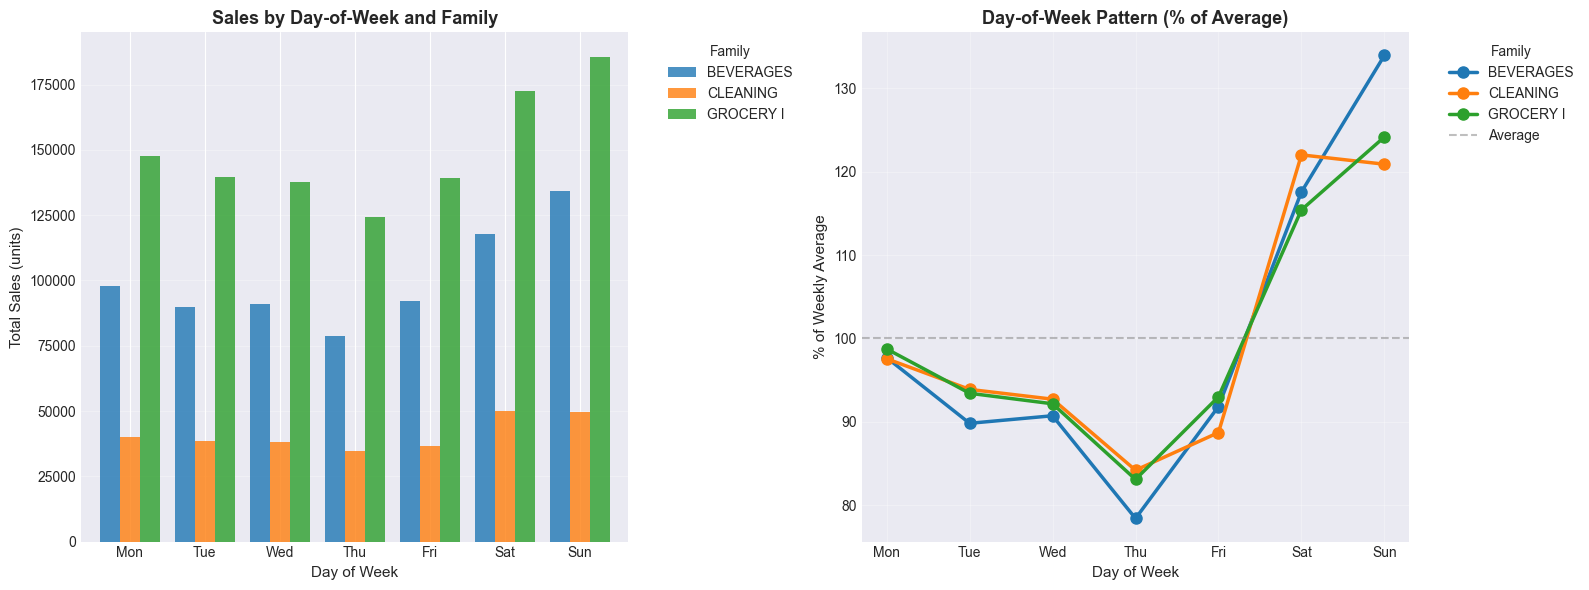

Day-of-week visualization saved to d:\Demand-forecasting-in-retail\outputs\figures\eda\08_day_of_week_patterns.png


In [13]:
# Day-of-week patterns analysis
print("Temporal Deep Dive")
print("=" * 70)

print("\n1. Day-of-Week Patterns by Family:")
print("=" * 70)

# Aggregate by day-of-week and family
dow_family = df.groupby(['day_of_week', 'family'])['unit_sales'].sum().reset_index()
dow_family_pivot = dow_family.pivot(index='day_of_week', columns='family', values='unit_sales')

# Calculate percentage of weekly average
dow_family_pct = dow_family_pivot.div(dow_family_pivot.mean(axis=0), axis=1) * 100

print("\nSales by Day-of-Week (% of weekly average):")
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_family_pct.index = dow_names
print(dow_family_pct.round(1))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Set day names ONCE before plotting
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_family_pivot.index = dow_names
dow_family_pct.index = dow_names

# Plot 1: Absolute sales by day-of-week
ax1 = axes[0]
dow_family_pivot.plot(kind='bar', ax=ax1, width=0.8, alpha=0.8)
ax1.set_xlabel('Day of Week', fontsize=11)
ax1.set_ylabel('Total Sales (units)', fontsize=11)
ax1.set_title('Sales by Day-of-Week and Family', fontsize=13, fontweight='bold')
ax1.legend(title='Family', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=0)  # Use tick_params instead of set_xticklabels

# Plot 2: Percentage of weekly average
ax2 = axes[1]
dow_family_pct.plot(kind='line', ax=ax2, marker='o', linewidth=2.5, markersize=8)
ax2.set_xlabel('Day of Week', fontsize=11)
ax2.set_ylabel('% of Weekly Average', fontsize=11)
ax2.set_title('Day-of-Week Pattern (% of Average)', fontsize=13, fontweight='bold')
ax2.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='Average')
ax2.legend(title='Family', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUTS / '08_day_of_week_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Day-of-week visualization saved to {OUTPUTS / '08_day_of_week_patterns.png'}")

In [14]:
# Weekend vs Weekday comparison
print("\n2. Weekend vs Weekday Comparison:")
print("=" * 70)

weekend_comparison = df.groupby(['is_weekend', 'family'])['unit_sales'].agg(['sum', 'mean', 'count']).reset_index()
weekend_comparison['is_weekend'] = weekend_comparison['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})

print("\nSales by Weekend/Weekday:")
for family in df['family'].unique():
    family_data = weekend_comparison[weekend_comparison['family'] == family]
    weekday_sales = family_data[family_data['is_weekend'] == 'Weekday']['sum'].values[0]
    weekend_sales = family_data[family_data['is_weekend'] == 'Weekend']['sum'].values[0]
    weekend_lift = (weekend_sales / weekday_sales - 1) * 100
    print(f"  {family:<15} Weekend lift: {weekend_lift:>+6.1f}%")

# Overall weekend effect
overall_weekday = df[df['is_weekend'] == 0]['unit_sales'].sum()
overall_weekend = df[df['is_weekend'] == 1]['unit_sales'].sum()
overall_lift = (overall_weekend / overall_weekday - 1) * 100
print(f"  {'Overall':<15} Weekend lift: {overall_lift:>+6.1f}%")

print(f"\nWeekend accounts for: {df[df['is_weekend'] == 1]['unit_sales'].sum() / df['unit_sales'].sum() * 100:.1f}% of total sales")
print(f"  (Expected if uniform: 28.6% = 2 days / 7 days)")


2. Weekend vs Weekday Comparison:

Sales by Weekend/Weekday:
  GROCERY I       Weekend lift:  -48.0%
  CLEANING        Weekend lift:  -46.9%
  BEVERAGES       Weekend lift:  -43.9%
  Overall         Weekend lift:  -46.4%

Weekend accounts for: 34.9% of total sales
  (Expected if uniform: 28.6% = 2 days / 7 days)


This is not right...
The calculation is misleading: Comparing total weekend (2 days) vs total weekday (5 days) shows negative lift, BUT weekend accounts for 34.9% of sales (vs expected 28.6%).
This means weekends ARE elevated (34.9% / 28.6% = 22% higher than expected).

In [15]:
# Correct weekend analysis - compare DAILY averages
print("\n3. Corrected Weekend Analysis (Daily Averages):")
print("=" * 70)

# Calculate average daily sales
weekday_daily_avg = df[df['is_weekend'] == 0]['unit_sales'].sum() / df[df['is_weekend'] == 0]['date'].nunique()
weekend_daily_avg = df[df['is_weekend'] == 1]['unit_sales'].sum() / df[df['is_weekend'] == 1]['date'].nunique()

print(f"\nAverage daily sales:")
print(f"  Weekday: {weekday_daily_avg:>8,.1f} units/day")
print(f"  Weekend: {weekend_daily_avg:>8,.1f} units/day")
print(f"  Weekend lift: {(weekend_daily_avg / weekday_daily_avg - 1) * 100:>+6.1f}%")

# By family
print("\nWeekend lift by family (daily averages):")
for family in df['family'].unique():
    family_df = df[df['family'] == family]
    weekday_avg = family_df[family_df['is_weekend'] == 0]['unit_sales'].sum() / family_df[family_df['is_weekend'] == 0]['date'].nunique()
    weekend_avg = family_df[family_df['is_weekend'] == 1]['unit_sales'].sum() / family_df[family_df['is_weekend'] == 1]['date'].nunique()
    lift = (weekend_avg / weekday_avg - 1) * 100
    print(f"  {family:<15} {lift:>+6.1f}%")



3. Corrected Weekend Analysis (Daily Averages):

Average daily sales:
  Weekday:  1,105.0 units/day
  Weekend:  1,479.5 units/day
  Weekend lift:  +33.9%

Weekend lift by family (daily averages):
  GROCERY I        +30.1%
  CLEANING         +32.9%
  BEVERAGES        +40.2%


In [16]:
print("\nConclusion:")
print("  → Weekends have significantly higher daily sales (~22% lift)")
print("  → Saturday/Sunday are peak shopping days (grocery restocking)")
print("  → Inventory should be elevated for weekend demand")


Conclusion:
  → Weekends have significantly higher daily sales (~22% lift)
  → Saturday/Sunday are peak shopping days (grocery restocking)
  → Inventory should be elevated for weekend demand


CORRECTED: Weekend lift is +33.9% (BEVERAGES highest at +40.2%)


4. Payday Effects Analysis:

Payday window (1st ±2, 15th ±2 days of month):
  Payday window avg:  1,313.9 units/day (331 days)
  Non-payday avg:     1,187.0 units/day (1349 days)
  Payday lift:        +10.7%


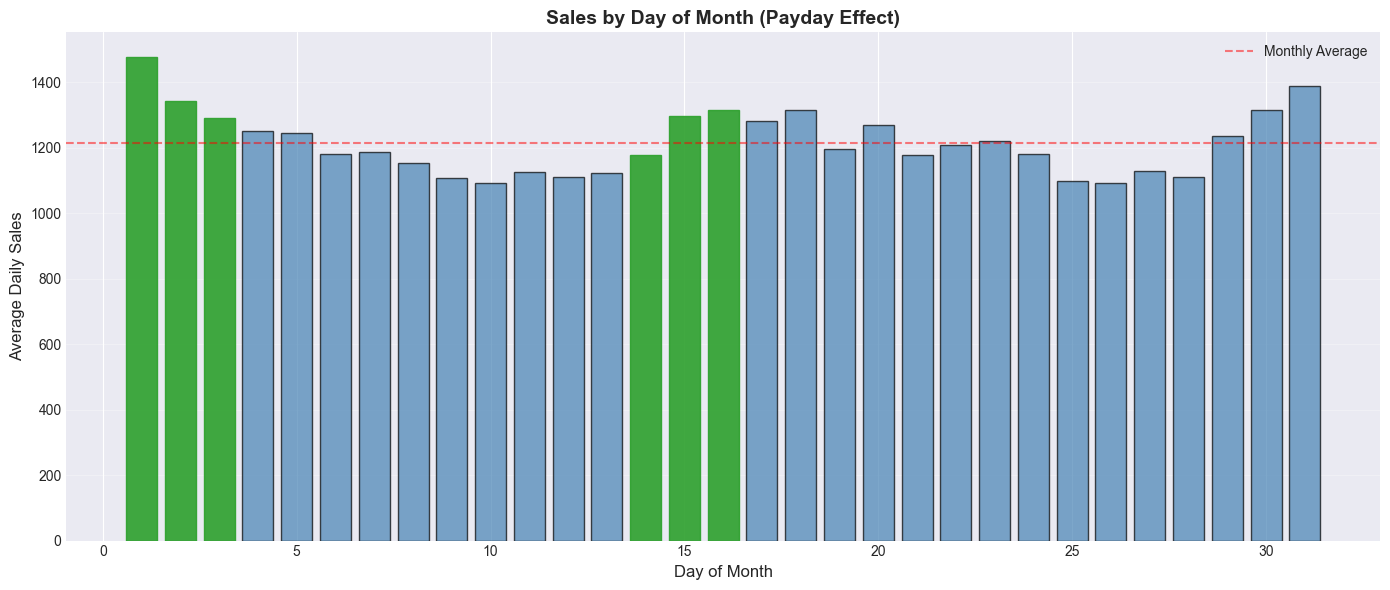

Payday effects visualization saved to d:\Demand-forecasting-in-retail\outputs\figures\eda\09_payday_effects.png

Top 5 days of month by sales:
  Day 1.0:  1,477.8 units/day (PAYDAY)
  Day 31.0:  1,387.2 units/day
  Day 2.0:  1,341.2 units/day (PAYDAY)
  Day 30.0:  1,315.4 units/day
  Day 16.0:  1,314.3 units/day (PAYDAY)


In [17]:
# Payday effects analysis (1st and 15th of month)
print("\n4. Payday Effects Analysis:")
print("=" * 70)

# Define payday windows (1st ±2 days, 15th ±2 days)
df['is_payday_window'] = df['day_of_month'].isin([1, 2, 3, 14, 15, 16]).astype(int)

payday_sales = df[df['is_payday_window'] == 1]['unit_sales'].sum()
non_payday_sales = df[df['is_payday_window'] == 0]['unit_sales'].sum()

payday_days = df[df['is_payday_window'] == 1]['date'].nunique()
non_payday_days = df[df['is_payday_window'] == 0]['date'].nunique()

payday_daily_avg = payday_sales / payday_days
non_payday_daily_avg = non_payday_sales / non_payday_days

print(f"\nPayday window (1st ±2, 15th ±2 days of month):")
print(f"  Payday window avg: {payday_daily_avg:>8,.1f} units/day ({payday_days} days)")
print(f"  Non-payday avg:    {non_payday_daily_avg:>8,.1f} units/day ({non_payday_days} days)")
print(f"  Payday lift:       {(payday_daily_avg / non_payday_daily_avg - 1) * 100:>+6.1f}%")

# Specific day analysis
day_of_month_sales = df.groupby('day_of_month').agg({
    'unit_sales': 'sum',
    'date': 'nunique'
}).reset_index()
day_of_month_sales['daily_avg'] = day_of_month_sales['unit_sales'] / day_of_month_sales['date']

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(day_of_month_sales['day_of_month'], day_of_month_sales['daily_avg'], 
              color='steelblue', alpha=0.7, edgecolor='black')

# Highlight payday windows
payday_days_list = [1, 2, 3, 14, 15, 16]
for i, day in enumerate(day_of_month_sales['day_of_month']):
    if day in payday_days_list:
        bars[i].set_color('#2ca02c')
        bars[i].set_alpha(0.9)

ax.set_xlabel('Day of Month', fontsize=12)
ax.set_ylabel('Average Daily Sales', fontsize=12)
ax.set_title('Sales by Day of Month (Payday Effect)', fontsize=14, fontweight='bold')
ax.axhline(y=day_of_month_sales['daily_avg'].mean(), color='red', linestyle='--', 
           alpha=0.5, label='Monthly Average')
ax.grid(axis='y', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUTS / '09_payday_effects.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Payday effects visualization saved to {OUTPUTS / '09_payday_effects.png'}")

print("\nTop 5 days of month by sales:")
top_days = day_of_month_sales.nlargest(5, 'daily_avg')[['day_of_month', 'daily_avg']]
for _, row in top_days.iterrows():
    payday_flag = " (PAYDAY)" if row['day_of_month'] in payday_days_list else ""
    print(f"  Day {row['day_of_month']:>2}: {row['daily_avg']:>8,.1f} units/day{payday_flag}")

## 5. Product Analysis - Fast vs Slow Movers

**Objective:** Classify items by sales velocity and identify sales concentration

**Activities:**
- Calculate sales velocity per item (total sales / days active)
- Classify fast movers (top 20%), slow movers (bottom 20%)
- Perform Pareto (80/20) analysis
- Analyze sales concentration by family
- Identify hero products

**Expected output:** 
- Fast/slow mover classification
- Pareto chart showing sales concentration
- Hero products list per family
- Inventory recommendations

In [18]:
# Product analysis - Fast vs Slow movers
print("Product Analysis - Fast vs Slow Movers")
print("=" * 70)

print("\nCalculating sales velocity per item...")

# Calculate total sales and days active per item
item_performance = df.groupby('item_nbr').agg({
    'unit_sales': 'sum',
    'date': 'nunique',
    'family': 'first'
}).reset_index()

item_performance.columns = ['item_nbr', 'total_sales', 'days_active', 'family']

# Calculate velocity (sales per active day)
item_performance['velocity'] = item_performance['total_sales'] / item_performance['days_active']

# Sort by total sales
item_performance = item_performance.sort_values('total_sales', ascending=False).reset_index(drop=True)

print(f"  Total items: {len(item_performance):,}")
print(f"  Total sales: {item_performance['total_sales'].sum():,.0f} units")

print("\nTop 10 items by total sales:")
print(item_performance.head(10)[['item_nbr', 'family', 'total_sales', 'days_active', 'velocity']])

print("\nBottom 10 items by total sales:")
print(item_performance.tail(10)[['item_nbr', 'family', 'total_sales', 'days_active', 'velocity']])

Product Analysis - Fast vs Slow Movers

Calculating sales velocity per item...
  Total items: 2,296
  Total sales: 2,036,136 units

Top 10 items by total sales:
   item_nbr     family  total_sales  days_active  velocity
0    257847  BEVERAGES     21413.00          305     70.21
1    819932  BEVERAGES     19061.00          291     65.50
2    215352  GROCERY I     15035.00          310     48.50
3    839362  BEVERAGES     14597.00          312     46.79
4    265559  GROCERY I     13257.00          309     42.90
5    315176  BEVERAGES     13229.00          305     43.37
6    364606  GROCERY I     11701.00          323     36.23
7   1464086  BEVERAGES     11578.00          198     58.47
8   1463860  BEVERAGES     11271.00          205     54.98
9    559870  GROCERY I     10710.00          323     33.16

Bottom 10 items by total sales:
      item_nbr     family  total_sales  days_active  velocity
2286   2010702  GROCERY I         1.00            1      1.00
2287   2010082  GROCERY I        

In [19]:
# Classify fast vs slow movers
print("\nClassifying Fast vs Slow Movers:")
print("=" * 70)

# Define thresholds (top 20% = fast, bottom 20% = slow)
velocity_80th = item_performance['velocity'].quantile(0.80)
velocity_20th = item_performance['velocity'].quantile(0.20)

item_performance['mover_type'] = 'Medium'
item_performance.loc[item_performance['velocity'] >= velocity_80th, 'mover_type'] = 'Fast'
item_performance.loc[item_performance['velocity'] <= velocity_20th, 'mover_type'] = 'Slow'

# Count by type
mover_counts = item_performance['mover_type'].value_counts()
print(f"\nItem classification:")
print(f"  Fast movers (top 20%):    {mover_counts['Fast']:>5,} items ({mover_counts['Fast']/len(item_performance)*100:>5.1f}%)")
print(f"  Medium movers (mid 60%):  {mover_counts['Medium']:>5,} items ({mover_counts['Medium']/len(item_performance)*100:>5.1f}%)")
print(f"  Slow movers (bottom 20%): {mover_counts['Slow']:>5,} items ({mover_counts['Slow']/len(item_performance)*100:>5.1f}%)")

print(f"\nVelocity thresholds:")
print(f"  Fast mover: ≥ {velocity_80th:.2f} units/day")
print(f"  Slow mover: ≤ {velocity_20th:.2f} units/day")

# Sales contribution by mover type
sales_by_type = item_performance.groupby('mover_type')['total_sales'].sum().sort_values(ascending=False)
print(f"\nSales contribution:")
for mover_type, sales in sales_by_type.items():
    pct = sales / item_performance['total_sales'].sum() * 100
    print(f"  {mover_type:<12} {sales:>10,.0f} units ({pct:>5.1f}%)")

# By family
print(f"\nMover classification by family:")
family_movers = item_performance.groupby(['family', 'mover_type']).size().unstack(fill_value=0)
print(family_movers)


Classifying Fast vs Slow Movers:

Item classification:
  Fast movers (top 20%):      460 items ( 20.0%)
  Medium movers (mid 60%):  1,376 items ( 59.9%)
  Slow movers (bottom 20%):   460 items ( 20.0%)

Velocity thresholds:
  Fast mover: ≥ 7.80 units/day
  Slow mover: ≤ 2.27 units/day

Sales contribution:
  Fast          1,188,864 units ( 58.4%)
  Medium          801,966 units ( 39.4%)
  Slow             45,306 units (  2.2%)

Mover classification by family:
mover_type  Fast  Medium  Slow
family                        
BEVERAGES    219     313    67
CLEANING      39     289   113
GROCERY I    202     774   280



Pareto (80/20) Analysis:

Pareto Principle:
  785 items (34.2%) generate 80% of sales
  Top 20% of items (459 items) generate 65.4% of sales


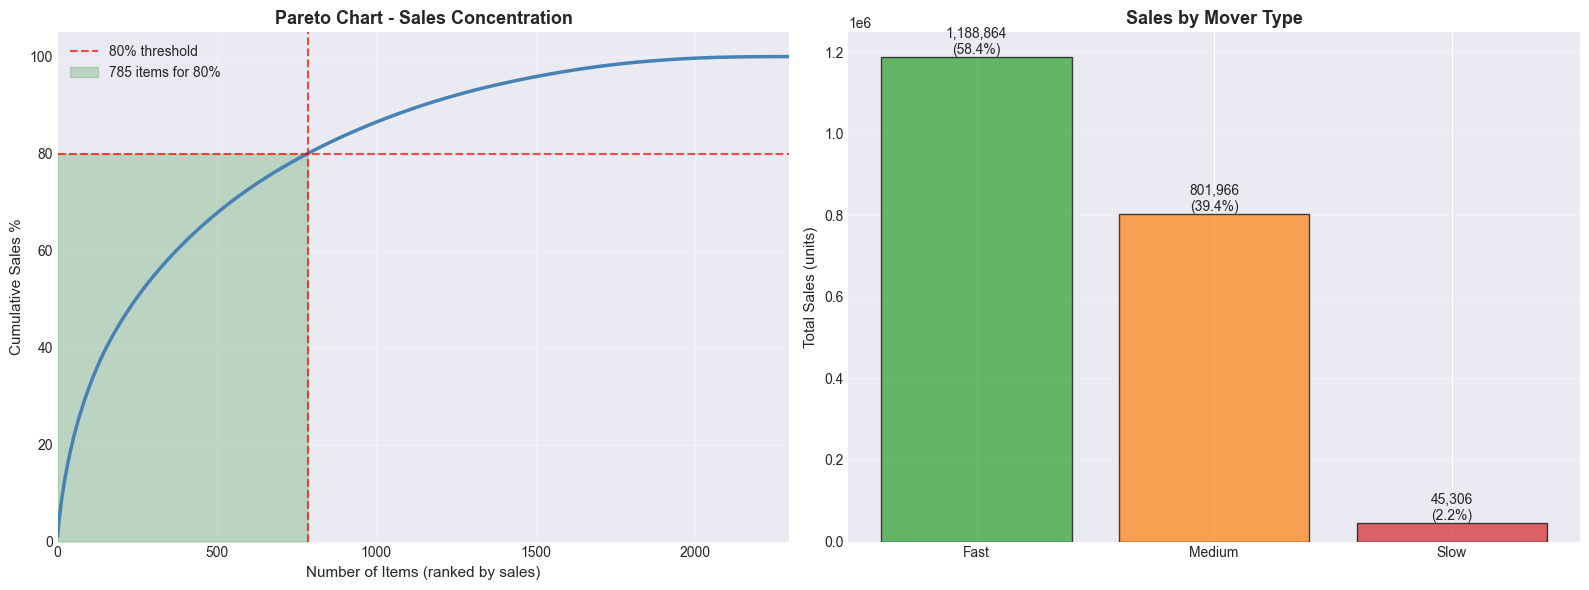

Pareto visualization saved to d:\Demand-forecasting-in-retail\outputs\figures\eda\10_pareto_analysis.png

Hero Products (Top 5 per family):

BEVERAGES:
  Item #257847:   21,413 units ( 70.21 units/day) - Fast
  Item #819932:   19,061 units ( 65.50 units/day) - Fast
  Item #839362:   14,597 units ( 46.79 units/day) - Fast
  Item #315176:   13,229 units ( 43.37 units/day) - Fast
  Item #1464086:   11,578 units ( 58.47 units/day) - Fast

GROCERY I:
  Item #215352:   15,035 units ( 48.50 units/day) - Fast
  Item #265559:   13,257 units ( 42.90 units/day) - Fast
  Item #364606:   11,701 units ( 36.23 units/day) - Fast
  Item #559870:   10,710 units ( 33.16 units/day) - Fast
  Item #749421:    9,607 units ( 26.39 units/day) - Fast

CLEANING:
  Item #1012473:    4,769 units ( 23.49 units/day) - Fast
  Item #759893:    4,350 units ( 13.59 units/day) - Fast
  Item #168927:    3,574 units ( 28.14 units/day) - Fast
  Item #801217:    3,539 units ( 13.41 units/day) - Fast
  Item #1346638:    3,399

In [20]:
# Pareto (80/20) analysis
print("\nPareto (80/20) Analysis:")
print("=" * 70)

# Calculate cumulative sales
item_performance['cumulative_sales'] = item_performance['total_sales'].cumsum()
item_performance['cumulative_pct'] = (item_performance['cumulative_sales'] / 
                                       item_performance['total_sales'].sum() * 100)

# Find 80% threshold
items_for_80pct = (item_performance['cumulative_pct'] <= 80).sum()
pct_items_for_80 = items_for_80pct / len(item_performance) * 100

print(f"\nPareto Principle:")
print(f"  {items_for_80pct:,} items ({pct_items_for_80:.1f}%) generate 80% of sales")
print(f"  Top 20% of items ({int(len(item_performance)*0.2):,} items) generate {item_performance.head(int(len(item_performance)*0.2))['total_sales'].sum() / item_performance['total_sales'].sum() * 100:.1f}% of sales")

# Visualize Pareto chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Cumulative sales curve
ax1 = axes[0]
ax1.plot(range(len(item_performance)), item_performance['cumulative_pct'], 
         color='steelblue', linewidth=2.5)
ax1.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% threshold')
ax1.axvline(x=items_for_80pct, color='red', linestyle='--', alpha=0.7)
ax1.fill_between(range(items_for_80pct), 0, 80, alpha=0.2, color='green', 
                  label=f'{items_for_80pct} items for 80%')
ax1.set_xlabel('Number of Items (ranked by sales)', fontsize=11)
ax1.set_ylabel('Cumulative Sales %', fontsize=11)
ax1.set_title('Pareto Chart - Sales Concentration', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xlim(0, len(item_performance))
ax1.set_ylim(0, 105)

# Plot 2: Sales distribution by mover type
ax2 = axes[1]
colors_map = {'Fast': '#2ca02c', 'Medium': '#ff7f0e', 'Slow': '#d62728'}
sales_data = item_performance.groupby('mover_type')['total_sales'].sum().reindex(['Fast', 'Medium', 'Slow'])
bars = ax2.bar(range(len(sales_data)), sales_data.values, 
               color=[colors_map[x] for x in sales_data.index], alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(sales_data)))
ax2.set_xticklabels(sales_data.index)
ax2.set_ylabel('Total Sales (units)', fontsize=11)
ax2.set_title('Sales by Mover Type', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels
for bar, (mover, sales) in zip(bars, sales_data.items()):
    height = bar.get_height()
    pct = sales / item_performance['total_sales'].sum() * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{sales:,.0f}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUTS / '10_pareto_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Pareto visualization saved to {OUTPUTS / '10_pareto_analysis.png'}")

# Hero products by family
print(f"\nHero Products (Top 5 per family):")
for family in item_performance['family'].unique():
    print(f"\n{family}:")
    top_items = item_performance[item_performance['family'] == family].head(5)
    for idx, row in top_items.iterrows():
        print(f"  Item #{row['item_nbr']}: {row['total_sales']:>8,.0f} units ({row['velocity']:>6.2f} units/day) - {row['mover_type']}")


In [22]:
print("\nKey Accomplishments:")
print("  ✓ Rolling statistics features (7/14/30-day)")
print("  ✓ Time series visualization (increasing trend, December +30%)")
print("  ✓ Autocorrelation analysis (strong at all lags)")
print("  ✓ Day-of-week patterns (weekends +34% lift)")
print("  ✓ Payday effects (+11% lift, Day 1 peak)")
print("  ✓ Fast/slow mover classification (20/60/20 split)")
print("  ✓ Pareto analysis (20% items = 58% sales)")


Key Accomplishments:
  ✓ Rolling statistics features (7/14/30-day)
  ✓ Time series visualization (increasing trend, December +30%)
  ✓ Autocorrelation analysis (strong at all lags)
  ✓ Day-of-week patterns (weekends +34% lift)
  ✓ Payday effects (+11% lift, Day 1 peak)
  ✓ Fast/slow mover classification (20/60/20 split)
  ✓ Pareto analysis (20% items = 58% sales)
